Epoch 1: Test Accuracy: 0.9104, Train Accuracy: 0.9155
Epoch 2: Test Accuracy: 0.9365, Train Accuracy: 0.9428
Epoch 3: Test Accuracy: 0.9498, Train Accuracy: 0.9568
Epoch 4: Test Accuracy: 0.9593, Train Accuracy: 0.9675
Epoch 5: Test Accuracy: 0.9636, Train Accuracy: 0.9733
Epoch 6: Test Accuracy: 0.9651, Train Accuracy: 0.9781
Epoch 7: Test Accuracy: 0.9676, Train Accuracy: 0.9789
Epoch 8: Test Accuracy: 0.9686, Train Accuracy: 0.9833
Epoch 9: Test Accuracy: 0.9702, Train Accuracy: 0.9843
Epoch 10: Test Accuracy: 0.9740, Train Accuracy: 0.9869


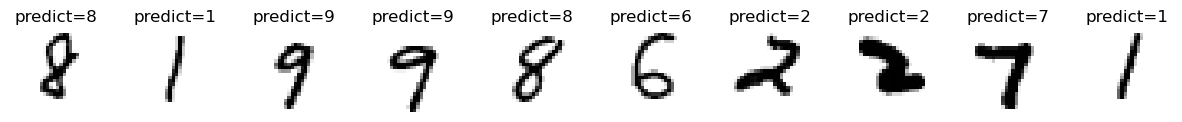

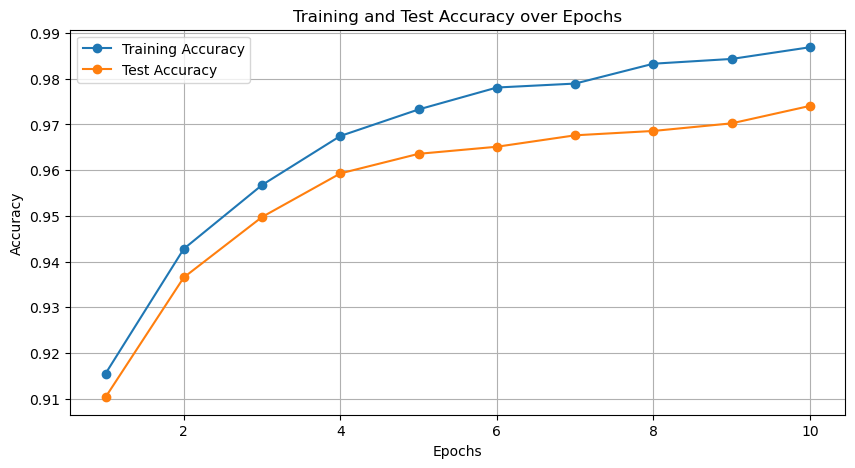

Confusion Matrix:
 [[810   0   0   2   0   0   1   0   2   1]
 [  0 902   3   0   1   1   1   0   1   0]
 [  5   4 816   5   6   0   0   1   7   2]
 [  2   0   1 916   0   4   0   1   9   4]
 [  2   0   0   0 818   0   3   0   0  16]
 [  0   1   0  13   0 673   6   0   3   6]
 [ 11   1   1   0   1   1 768   0   2   0]
 [  0   1   5   8   3   1   0 868   0   7]
 [  7   3   2  15   1   5   6   1 788   7]
 [  0   2   1   4   2   1   0   4   1 823]]
Precision: 0.9744
Recall: 0.9737
F1-Score: 0.9739


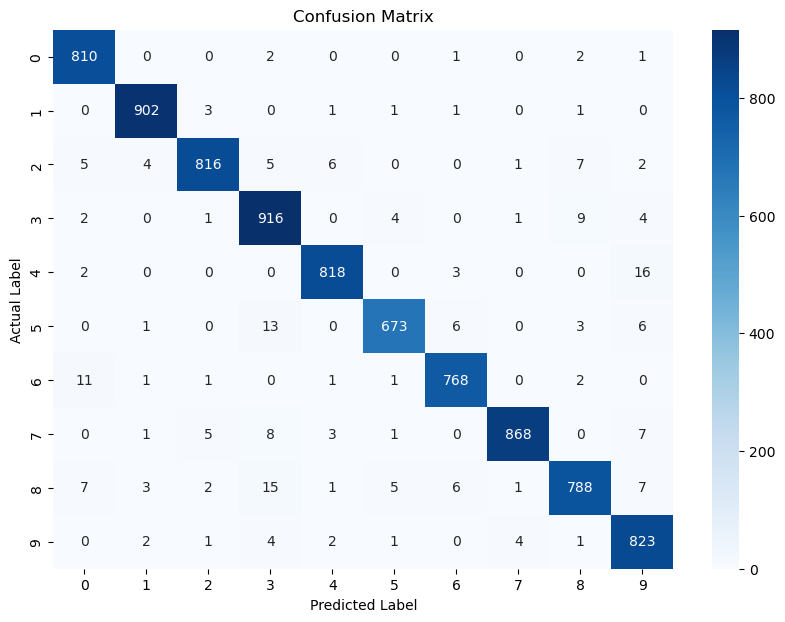

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

# Load and preprocess data
train_data = pd.read_csv("./train.csv")
quiz_data = pd.read_csv("./test.csv")
X, T = train_data.iloc[:, 1:], train_data.iloc[:, [0]]
X = X.to_numpy() #features
T = T.to_numpy() #labels
x_train, x_test, t_train, t_test = train_test_split(X, T, test_size=0.2, random_state=42)
x_train = x_train.reshape(-1, 1, 28, 28) / 255.0 #adjusted to size 28x28, divided by 255 for normalization
x_test = x_test.reshape(-1, 1, 28, 28) / 255.0
t_train = np.eye(10)[t_train.astype("int")].reshape(-1, 10)
t_test = np.eye(10)[t_test.astype("int")].reshape(-1, 10)
quiz_x = quiz_data.to_numpy().reshape(-1, 1, 28, 28) / 255.0

#Softmax function to transform it into probabilities 
def softmax(x):
    if x.ndim == 2:
        x = x - np.max(x, axis=1, keepdims=True)
        exp_x = np.exp(x)
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)
    else:
        x = x - np.max(x)
        exp_x = np.exp(x)
        return exp_x / np.sum(exp_x)

#Cross entropy error to calculate the difference between the distribution of the transformed probabilities and the actual label
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
    if t.size == y.size:
        t = t.argmax(axis=1)
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size


#Soft max with loss function to Combining the softmax activation function with the cross entropy loss into a single class
class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None
        self.y = None
        self.t = None

    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)
        return self.loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        if self.t.size == self.y.size:
            dx = (self.y - self.t) / batch_size
        else:
            dx = self.y.copy()
            dx[np.arange(batch_size), self.t] -= 1
            dx /= batch_size
        return dx

#im2col & col2im to Calculate efficiently and easily parallelize
def im2col(input_data, filter_h, filter_w, stride=1, pad=0):
    N, C, H, W = input_data.shape #N = Num, C = Channel, H = Height, W = Width
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1

    img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))

    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]

    col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1)
    return col

def col2im(col, input_shape, filter_h, filter_w, stride=1, pad=0):
    N, C, H, W = input_shape #N = Num, C = Channel, H = Height, W = Width
    H += 2 * pad
    W += 2 * pad
    x = np.zeros((N, C, H, W), dtype=col.dtype)
    out_h = (H - filter_h) // stride + 1
    out_w = (W - filter_w) // stride + 1

    col = col.reshape(N, out_h, out_w, C, filter_h, filter_w).transpose(0, 3, 4, 5, 1, 2)

    for y in range(filter_h):
        y_max = y + stride * out_h
        for x in range(filter_w):
            x_max = x + stride * out_w
            x[:, :, y:y_max:stride, x:x_max:stride] += col[:, :, y, x, :, :]

    if pad > 0:
        return x[:, :, pad:-pad, pad:-pad]
    else:
        return x

#Convolution
class Convolution:
    def __init__(self, W, b, stride=1, pad=0):
        self.W = W
        self.b = b
        self.stride = stride
        self.pad = pad
        self.x = None
        self.dW = None
        self.db = None

    def forward(self, x):
        self.x = x
        FN, C, FH, FW = self.W.shape #FN = number of filters, C = Number of Channles, FH = filters height, FW = filters width
        N, C, H, W = x.shape
        out_h = int((H + 2 * self.pad - FH) / self.stride + 1)
        out_w = int((W + 2 * self.pad - FW) / self.stride + 1)
        out = np.zeros((N, FN, out_h, out_w))
        x_padded = np.pad(x, [(0,0), (0,0), (self.pad, self.pad), (self.pad, self.pad)], 'constant')
        for n in range(N):
            for f in range(FN):
                for i in range(out_h):
                    for j in range(out_w):
                        out[n, f, i, j] = np.sum(
                            x_padded[n, :, i*self.stride:i*self.stride+FH, j*self.stride:j*self.stride+FW] * self.W[f, :, :, :]
                        ) + self.b[f]
        return out

    def backward(self, dout):
        FN, C, FH, FW = self.W.shape
        N, C, H, W = self.x.shape
        x_padded = np.pad(self.x, [(0,0), (0,0), (self.pad, self.pad), (self.pad, self.pad)], 'constant')
        dx_padded = np.zeros_like(x_padded)
        dW = np.zeros_like(self.W)
        db = np.zeros_like(self.b)
        for n in range(N):
            for f in range(FN):
                for i in range(dout.shape[2]):
                    for j in range(dout.shape[3]):
                        db[f] += dout[n, f, i, j]
                        current_region = x_padded[n, :, i*self.stride:i*self.stride+FH, j*self.stride:j*self.stride+FW]
                        dW[f] += current_region * dout[n, f, i, j]
                        dx_padded[n, :, i*self.stride:i*self.stride+FH, j*self.stride:j*self.stride+FW] += self.W[f] * dout[n, f, i, j]
        if self.pad > 0:
            dx = dx_padded[:, :, self.pad:-self.pad, self.pad:-self.pad]
        else:
            dx = dx_padded
        self.dW = dW
        self.db = db
        return dx

#Relu function
class Relu:
    def __init__(self):
        self.mask = None

    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0
        return out

    def backward(self, dout):
        dout[self.mask] = 0
        return dout

#Pooling layer
class Pooling:
    def __init__(self, pool_h, pool_w, stride=1, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad
        self.x = None  # Ensure x is defined as an attribute
        self.arg_max = None

    def forward(self, x):
        self.x = x  # Store the input x during the forward pass
        N, C, H, W = x.shape
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (W - self.pool_w) / self.stride)
        out = np.zeros((N, C, out_h, out_w))
        self.arg_max = np.zeros((N, C, out_h, out_w), dtype=int)

        for n in range(N):
            for c in range(C):
                for i in range(out_h):
                    for j in range(out_w):
                        row_start = i * self.stride
                        row_end = row_start + self.pool_h
                        col_start = j * self.stride
                        col_end = col_start + self.pool_w
                        pool_region = x[n, c, row_start:row_end, col_start:col_end]
                        max_index = np.argmax(pool_region)
                        self.arg_max[n, c, i, j] = max_index
                        out[n, c, i, j] = np.max(pool_region)
        return out

    def backward(self, dout):
        N, C, H, W = self.x.shape
        dX = np.zeros_like(self.x)
        out_h = dout.shape[2]
        out_w = dout.shape[3]

        for n in range(N):
            for c in range(C):
                for i in range(out_h):
                    for j in range(out_w):
                        max_index = self.arg_max[n, c, i, j]
                        max_row = i * self.stride + max_index // self.pool_w
                        max_col = j * self.stride + max_index % self.pool_w
                        dX[n, c, max_row, max_col] += dout[n, c, i, j]
        return dX

#Affine layer
class Affine:
    def __init__(self, W, b):
        self.W = W
        self.b = b
        self.x = None
        self.original_x_shape = None

    def forward(self, x):
        self.original_x_shape = x.shape
        x = x.reshape(x.shape[0], -1)
        self.x = x
        out = np.dot(x, self.W) + self.b
        return out

    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        dx = dx.reshape(self.original_x_shape)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)
        return dx

#Traing using Adam optimizer
class Adam:
    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.m = {}
        self.v = {}
        self.t = 0

    def update(self, params, grads):
        self.t += 1
        if not self.m:
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)
        
        for key in params.keys():
            self.m[key] = self.beta1 * self.m[key] + (1 - self.beta1) * grads[key]
            self.v[key] = self.beta2 * self.v[key] + (1 - self.beta2) * (grads[key] ** 2)
            m_corrected = self.m[key] / (1 - self.beta1 ** self.t)
            v_corrected = self.v[key] / (1 - self.beta2 ** self.t)
            params[key] -= self.lr * m_corrected / (np.sqrt(v_corrected) + self.epsilon)

#CNN
class SimpleConvNet:
    def __init__(self):
        filter_num = 10
        filter_size = 3
        stride = 1
        pad = 1
        input_size = 28
        hidden_size = 100
        output_size = 10
        conv_output_size = (input_size - filter_size + 2 * pad) // stride + 1
        pool_output_size = (conv_output_size // 2) * (conv_output_size // 2) * filter_num
        self.params = {}
        self.params['W1'] = np.random.randn(filter_num, 1, filter_size, filter_size) * 0.01
        self.params['b1'] = np.zeros(filter_num)
        self.params['W2'] = np.random.randn(pool_output_size, hidden_size) * 0.01
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = np.random.randn(hidden_size, output_size) * 0.01
        self.params['b3'] = np.zeros(output_size)
        self.layers = {
            'Conv1': Convolution(self.params['W1'], self.params['b1'], stride, pad),
            'Relu1': Relu(),
            'Pool1': Pooling(2, 2, 2),
            'Affine1': Affine(self.params['W2'], self.params['b2']),
            'Relu2': Relu(),
            'Affine2': Affine(self.params['W3'], self.params['b3'])
        }
        self.last_layer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        return x

    def loss(self, x, t):
        y = self.predict(x)
        return self.last_layer.forward(y, t)

    def gradient(self, x, t):
        self.loss(x, t)
        dout = 1
        dout = self.last_layer.backward(dout)
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db
        grads['W2'], grads['b2'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W3'], grads['b3'] = self.layers['Affine2'].dW, self.layers['Affine2'].db
        return grads

    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1:
            t = np.argmax(t, axis=1)
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy


num_epochs = 10
def train(network, x_train, t_train, x_test, t_test, epochs, mini_batch_size, optimizer):
    train_accuracies = []
    test_accuracies = []
    
    for epoch in range(epochs):
        perm = np.random.permutation(len(x_train))
        for i in range(0, len(x_train), mini_batch_size):
            x_batch = x_train[perm[i:i + mini_batch_size]]
            t_batch = t_train[perm[i:i + mini_batch_size]]
            grads = network.gradient(x_batch, t_batch)
            optimizer.update(network.params, grads)

        # Calculate test and training accuracy after Epoch termination
        test_acc = network.accuracy(x_test, t_test)
        train_acc = network.accuracy(x_train, t_train)
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)
        print(f'Epoch {epoch + 1}: Test Accuracy: {test_acc:.4f}, Train Accuracy: {train_acc:.4f}')

    return train_accuracies, test_accuracies

# Run model initialization and learning
network = SimpleConvNet()
optimizer = Adam(lr=0.001)
train_accuracies, test_accuracies = train(network, x_train, t_train, x_test, t_test, num_epochs, mini_batch_size=100, optimizer=optimizer)

#predict the model
y_test_pred = network.predict(x_test)
results = y_test_pred.argmax(axis=1)
plt.figure(figsize=(15,6))
for i in range(10): 
    plt.subplot(4, 10, i+1)
    plt.imshow(x_test[i].reshape((28,28)), cmap=plt.cm.binary)
    plt.title(f"predict={results[i]}", y=0.9)
    plt.axis('off')
plt.subplots_adjust(wspace=0.3, hspace=-0.1)
plt.show()

# Display training and testing accuracies graph
epochs = list(range(1, num_epochs + 1))
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_accuracies, label='Training Accuracy', marker='o')
plt.plot(epochs, test_accuracies, label='Test Accuracy', marker='o')
plt.title('Training and Test Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


def calculate_performance_metrics(y_true, y_pred):
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:\n", cm)

    # Precision, Recall, F1-Score
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")

    return cm, precision, recall, f1

# Assuming you have already made predictions and have the true labels ready
t_test_labels = np.argmax(t_test, axis=1)  # Converting one-hot encoded labels back to normal label

# Calculate performance metrics
confusion_matrix, precision, recall, f1_score = calculate_performance_metrics(t_test_labels, results)

plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()








